In [1]:
import pickle as pkl, pandas as pd, numpy as np, json, csv ,random, timeit, re

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from descartes import PolygonPatch

from collections import OrderedDict

import matplotlib as mpl
from matplotlib import pyplot as plt

from collections import OrderedDict

In [2]:
# %run ../src/geo_utils.py

import numpy as np
from scipy.spatial.distance import cdist
from shapely.geometry import Point, MultiPoint


R = 6365.902 #km; Radius of the earth at a location within Germany.

def jacobian_sq(latitude):
    """
        jacobian_sq(latitude)
        
    Computes the "square root" (Cholesky factor) of the Jacobian of the cartesian projection from polar coordinates (in degrees longitude, latitude) onto cartesian coordinates (in km east/west, north/south) at a given latitude (the projection's Jacobian is invariante wrt. longitude).
    """
    return R*(np.pi/180.0)*np.array([[np.abs(np.cos(np.deg2rad(latitude))), 0.0],[0.0, 1.0]])

def compute_interaction(tp_1, tp_2, σs):
    """
        compute_interaction(tp_1, tp_2, σs)
    
    For interaction effects between two counties, Gaussian basis functions with radii σs are applied to the distances between all pairs of testpoints from both counties and averaged.
    
    Arguments:
    ==========
        tp_1:       representative testpoints from within county 1
        tp_2:       representative testpoints from within county 2
        σs:         standard deviations of the Gaussian basis-functions
    """
    centroid = (tp_1.mean(axis=0) + tp_2.mean(axis=0))/2
    Σ_sq = jacobian_sq(centroid[1])
    dx = cdist(tp_1, tp_2, "mahalanobis", VI=Σ_sq**2)

    interaction = np.zeros_like(σs)
    for k,σ in enumerate(σs):
        interaction[k] = np.mean(np.exp(-0.5*(dx/σ)**2)/np.sqrt(2*np.pi*σ**2))
    return interaction
    
    
    
def compute_loss(shape, testpoints, σs, ϵ = np.random.randn(100,2)):
    """
        compute_loss(shape, testpoints, σs, ϵ)
        
    For interaction effects between two counties, Gaussian basis functions are applied to the distance between testpoints from both counties. Cases occuring outside the `shape` of the region for which the reported cases are known should similarly contribute to interaction effects, but are missing in the dataset. To compensate for this bias, the expected fraction of 'mass' that a basis function centered around a testpoint in the county would assign to points outside the region of interest is estimated through rejection sampling.
    
    Arguments:
    ==========
        
        shape:      the shape of the region of interest surrounding the county
        testpoints: representative testpoints from within the county
        σs:         standard deviations of the Gaussian basis-functions
        ϵ:          noise term used for sampling points (num_partition_samples × 2)
    """
    borderlosses = np.zeros(len(σs))
    for tp in testpoints:
        Σ_sq = jacobian_sq(tp[1])
        Σ_sqinv = np.diag(1/np.diag(Σ_sq))

        # draw points surrounding testpoint in a Gaussian with radius 1km
        other_offsets = ϵ.dot(Σ_sqinv.T)

        # check border effects for each radius
        for j,σ in enumerate(σs):
            # draw samples around each testpoint in the county and check if they land in the region
            smp = MultiPoint(tp+other_offsets*σ)
            pts = shape.intersection(smp)
            borderlosses[j] += (1 if isinstance(pts, Point) else len(pts))
    return np.clip(borderlosses/(len(testpoints)*len(ϵ)), 0.0, 1.0)


# Compute county specific information

* `num_testpoints_per_county` define how many testpoints to sample inside each county. Testpoints are used to estimate location dependent features.
* `num_partition_samples` defines how many points to sample when estimating partition functions (i.e. the effective area inside vs. outside the borders) for border effects
* `num_interaction_gaussians` defines how many spatial basis functions to use in the precalculation of border- and interaction-effects. (The training/evaluation/testing of our model assumes this to be `4`; changes here need to be reflected in the corresponding scripts.)
* `interaction_distance` defines the standard deviation of the largest Gaussian spatial basis function in kilometers. Other basis functions are scaled to $$\sigma s[i] = \frac{2^{i-1} \cdot \text{interaction_distance}}{\text{num_interaction_gaussians}} \quad \text{ for } i\in\{0,\dots,\text{num_interaction_gaussians}-1\}.$$ For the default values (`num_interaction_gaussians=4, interaction_distance=50km`), the resulting basis functions are of standard deviation 6.25km, 12.5km, 25km, 50km.

In [3]:
num_testpoints_per_county = 500
num_partition_samples = 500

num_interaction_gaussians = 4
interaction_distance = 50.0 #[km]
σs= 2**np.arange(num_interaction_gaussians)/(2*num_interaction_gaussians)*interaction_distance

counties = OrderedDict()

## Extract county shapes

Load shapes of counties from the JSON file and convert them to `shapely.(Multi)Polygon` objects. Counties are referenced by the RKI ID, related to the ferderal county ID ([AGS](https://de.wikipedia.org/wiki/Amtlicher_Gemeindeschl%C3%BCssel)), as well as the German name.

In [4]:
with open("../data/raw/germany_county_shapes.json", 'r') as data_file:
    shape_data = json.load(data_file)

for idx,val in enumerate(shape_data["features"]):
    id_current = val["properties"]["RKI_ID"]
    name_current = val["properties"]["RKI_NameDE"]
    
    if val["geometry"]["type"] == "Polygon":
        polygon_current = Polygon(val["geometry"]["coordinates"][0],val["geometry"]["coordinates"][1:])
    elif val["geometry"]["type"] == "MultiPolygon":
        polys = [Polygon(p[0], p[1:]) for p in val["geometry"]["coordinates"]]
        polygon_current = MultiPolygon(polys)
    
    counties[id_current] = {"shape": polygon_current, "name": name_current}

In [5]:
# Sanity check: the city of Osnabrueck has the ID 03404
assert counties["03404"]["name"] == "SK Osnabrück"

## Extract county-demographics

Create look-up of county ids by name.

In [6]:
county_names = dict([(val["name"], id) for id,val in counties.items()])

Load yearly demographics data and aggregate it into 4 age groups ([0-5), [5-20), [20-65), >65). For each group and each year, the logarithm of the respective fraction of total population is used as feature. The yearly total population numbers are used as the exposure in the log-link GLM.

In [7]:
age_data = pd.read_csv("../data/raw/germany_population_data.csv")[["county","age_group","year","population"]]

pat = re.compile("A([0-9]+).*")

def merge_age_groups(age_group):
    starting_age = int(pat.match(age_group).group(1))
    
    if starting_age <5:
        return "[0-5)"
    elif starting_age <20:
        return "[5-20)"
    elif starting_age < 65:
        return "[20-65)"
    else:
        return ">65"

age_data["age_group"] = age_data["age_group"].apply(merge_age_groups)
age_data["id"] = age_data["county"].apply(county_names.get)

#get total number of people per county per year
total_population_data = age_data.groupby(["id","year"]).aggregate({"population": 'sum'})
#get total number of people per county per age group per year
group_population_data = age_data.groupby(["id","age_group","year"]).aggregate({"population": 'sum'})
#calculate the log age group fraction of the total population
log_group_fraction_data = group_population_data.apply(lambda row: np.log(row/total_population_data.loc[(row.name[0],row.name[2])]), axis=1)
#create group "total" column
total_population_data["age_group"]="total"
total_population_data.reset_index(inplace=True)
total_population_data.set_index(["id","age_group","year"], inplace=True)

#combine age groups and the "total" column into a single dataframe and export the "population" column as values in a dictionary
population_data = pd.concat([log_group_fraction_data, total_population_data])

Insert the demographic data (as a dictionary) of each county into the `counties` dictionary under the key "demographics".

In [8]:
for id,row in population_data.unstack(1).unstack(1).iterrows():
    counties[id]["demographics"] = row["population"].to_dict()

## Sample testpoints for each county

Draw `num_testpoints_per_county` points geographically uniformly within the county boundaries via rejection sampling. To this end, the Jacobian of a geographical projection from polar coordinates (latitude,longitude) to cartesian coordinates (x,y), is evaluated at the centroid of the county and used to convert between degrees and km.

In [9]:
for i,(id, county) in enumerate(counties.items()):
    print("Sampling testpoints for county '{}' ({:.2f}%)            ".format(id, 100.0*i/len(counties)), end="\r")
    # Sample uniformly in the region using local jacobian
    centroid = np.array(county["shape"].centroid)
    Σ_sq = jacobian_sq(centroid[1])
    Σ_sqinv = np.diag(1/np.diag(Σ_sq))
    
    x1,y1,x2,y2 = county["shape"].bounds
    p1 = np.array([x1,y1])
    p2 = np.array([x2,y2])
    
    p1_corrected = (p1-centroid).dot(Σ_sq)
    p2_corrected = (p2-centroid).dot(Σ_sq)
    
    dims = p2_corrected-p1_corrected
    
    # calculate testpoints
    testpoints = np.empty((num_testpoints_per_county, 2), np.float)
    
    cnt = 0
    while cnt < num_testpoints_per_county:
        tp = (np.random.rand(2)*dims).dot(Σ_sqinv) + p1
        if not county["shape"].contains(Point(tp)):
            continue
        testpoints[cnt, :] = tp
        cnt += 1

        counties[id]["testpoints"] = testpoints

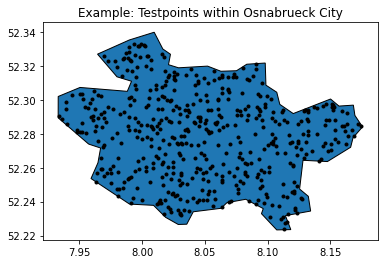

In [10]:
ax = plt.subplot(111)
ax.add_patch(PolygonPatch(counties["03404"]["shape"]))
ax.plot(counties["03404"]["testpoints"][:,0],counties["03404"]["testpoints"][:,1], "k.")
ax.set_title("Example: Testpoints within Osnabrueck City");

## Calculate region specific features

Assign counties to regions. Some diseases may be specific to given regions (such as Boreliosis, which, within Germany, is more prevalent in the south and thus not reported in many states), so regional predictions should be made. 
Each region is assumed to be surrounded by area for which no data is available, but where the statistics of the disease at hand are similar across the border. The resulting bias towards underestimating infections due to the lack of reported cases beyond the border must be compensated. This is achieved by scaling up the interaction effect contributions.

In [11]:
regions = OrderedDict({
    "germany": {"ids": list(counties.keys()), "hatch": "+"},
    "bavaria": {"ids": list(filter(lambda x: x.startswith("09"), counties.keys())), "hatch": "\\"},
    "east":    {"ids": list(filter(lambda x: x[:2] > "11", counties.keys())), "hatch": "/"},
    "berlin":  {"ids": list(filter(lambda x: x.startswith("11"), counties.keys())), "hatch": "o"}
})

In [12]:
for county in counties.values():
    county["region"] = []
    
for region, props in regions.items():
    for id in props["ids"]:
        counties[id]["region"].append(region)

Create patches for each region.

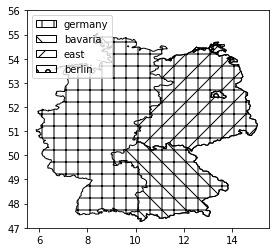

In [13]:
ax = plt.subplot(111)
# calculate region polygons
for name,region in regions.items():
    region_poly = Polygon()
    for c in region["ids"]:
        region_poly = region_poly.union(counties[c]["shape"])

    # simplify polygon structure
    region_poly = region_poly.buffer(0.01).simplify(0.01).buffer(-0.01)

    region["shape"] = region_poly
    patch = PolygonPatch(region_poly, fill=False, label=name, hatch=region["hatch"])
    ax.add_patch(patch)

ax.legend()
ax.set_aspect(1.0)
ax.set_xlim(5.5,15.5)
ax.set_ylim(47,56)
plt.show()

### Calculate border effects

Calculate the scaling factors to compensate border-loss effects of a given region for each county in that region.

In [14]:
# precomputed noise
ϵ = np.random.randn(num_partition_samples, 2)

for i,(id,county) in enumerate(counties.items()):
    county["borderloss"] = {}
    for j,(name,region) in enumerate(regions.items()):
        if id not in region["ids"]:
            continue
        
        print("Calculating border effects for county '{}' in region '{}' ({:.2f}%)                      ".format(id, name, 100.0*((i*len(regions)+j)/(len(counties)*len(regions)))), end="\r")
        county["borderloss"][name] = compute_loss(region["shape"], county["testpoints"], σs, ϵ)

In [ ]:
# compute_loss?

To verify, plot the computed county-wise border-loss effects for each region and at each interaction distance.

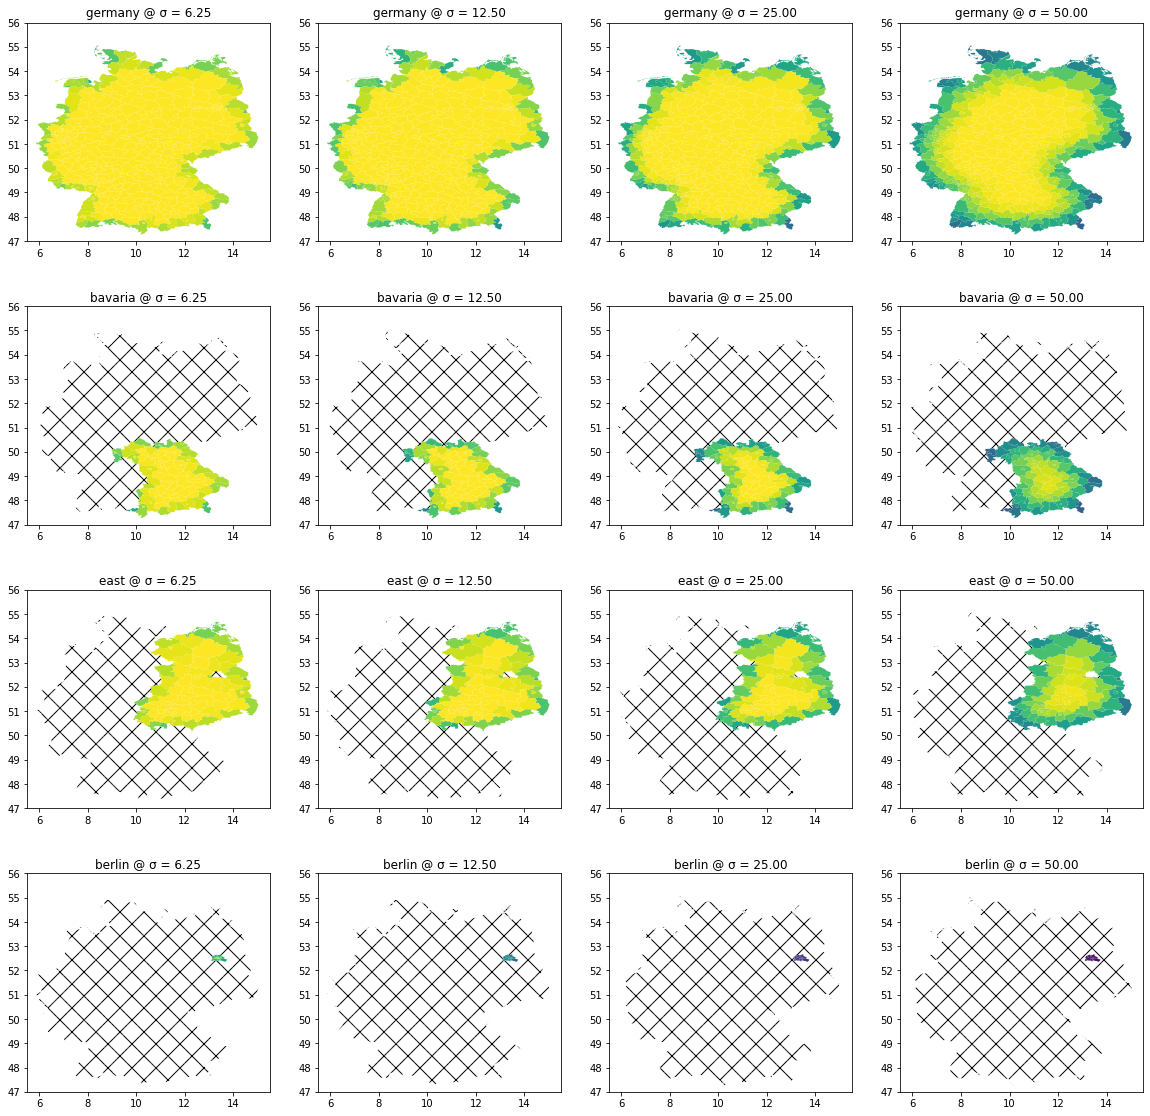

In [15]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(0.0, 1.0)

fig = plt.figure(figsize=(5*len(σs), 5*len(regions)))
# calculate region polygons
for i,r in enumerate(regions.keys()):
    for j,σ in enumerate(σs):
        ax = fig.add_subplot(len(regions), 4, i*4+j+1, aspect=1.0)
        for k,(rid, county) in enumerate(counties.items()):
            if r in county["borderloss"]:
                ax.add_patch(PolygonPatch(county["shape"], lw=0, fc=cmap.to_rgba(county["borderloss"][r][j])))
            else:
                ax.add_patch(PolygonPatch(county["shape"], lw=0, fill=False, hatch="x"))
        ax.set_aspect(1.0)
        ax.set_xlim(5.5,15.5)
        ax.set_ylim(47,56)
        ax.set_title("{} @ σ = {:.2f}".format(r,σ))
plt.show(fig)

Save all county-specific information as a dictionary to a pickled file.

In [16]:
with open('../data/counties/counties.pkl',"wb") as f:
    pkl.dump(counties,f)

# Compute county-county interactions

Infections in one county (A) can influence the probability of a person in another county (B) becoming infected at a later time. Since the precise locations of cases within the county A is not reported and the precise location where people live in county B is not used, this interaction depends on the expected geographical distance between randomly sampled locations (testpoints) in counties A and B, respectively. To model the distance dependent effect, Gaussian basis functions with standard deviations `σs` are used as features. For each county, the interaction effects originating from each other county are aggregated.

In [17]:
factor = np.empty((len(counties),len(counties),len(σs)), np.float64)

for i,(id_1, county_1) in enumerate(counties.items()):
    for j,(id_2, county_2) in enumerate(counties.items()):
        if j < i:
            factor[i,j,:] = factor[j,i,:]
            continue
        print("Calculating interaction effects for counties '{}' and '{}' ({:.2f}%)            ".format(id_1, id_2, 100.0*(i+j/len(counties))/len(counties)), end="\r")
        factor[i,j,:] = compute_interaction(county_1["testpoints"], county_2["testpoints"], σs)

Visualizing the interaction effects on Osnabrueck shows decreasing influence of counties at larger distance, with the county surrounding Osnabrueck exhibiting the strongest influence at a medium distance.

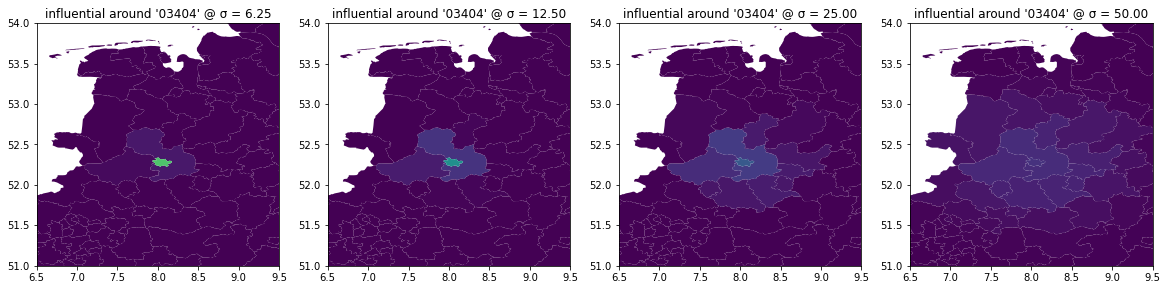

In [18]:
cmap = mpl.cm.ScalarMappable(cmap=mpl.cm.viridis)
cmap.set_clim(factor.min(), factor.max())

i = list(counties.keys()).index("03404")

fig = plt.figure(figsize=(5*len(σs), 5))
for j,σ in enumerate(σs):
    ax = fig.add_subplot(1, len(σs), j+1, aspect=1.0)
    for k,(rid, county) in enumerate(counties.items()):
        ax.add_patch(PolygonPatch(county["shape"], lw=0, fc=cmap.to_rgba(factor[i,k,j])))
    ax.set_xlim(6.5,9.5)
    ax.set_ylim(51,54)
    ax.set_title("influential around '03404' @ σ = {:.2f}".format(σ))
plt.show(fig)

Save the interaction effects as a 3D array (#counties  × #counties  × `num_interaction_gaussians`).

In [19]:
np.save("../data/counties/interaction_effects.npy", factor)